# Init.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import(
    mean_absolute_error as MAE,
    mean_squared_error as MSE,
    mean_absolute_percentage_error as MAPE,
)

# Prep.

In [2]:
data = pd.read_parquet("./data/trip_data_clean.parquet")
data.info()
data.sample(5)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4146632 entries, 0 to 4146631
Data columns (total 6 columns):
 #   Column           Dtype  
---  ------           -----  
 0   trip_distance    float32
 1   VendorID         uint8  
 2   passenger_count  int64  
 3   pickup_hour      uint8  
 4   pickup_day       uint8  
 5   fare_amount      float32
dtypes: float32(2), int64(1), uint8(3)
memory usage: 75.1 MB


,trip_distance,VendorID,passenger_count,pickup_hour,pickup_day,fare_amount
2111144,20.16,2,1,14,3,75.120003
147571,2.01,2,1,9,1,14.200000
429657,6.04,2,1,18,4,24.700001
2391543,2.99,2,1,5,5,13.900000
3304257,12.80,1,1,16,1,52.000000


## Split Data

In [3]:
features = data.columns[:-1]
target = data.columns[-1]

# scaler = StandardScaler()
# data[features] = scaler.fit_transform(data[features])

X = data[features]
y = data[target]

X_train, X_test, y_train, y_test = train_test_split(
    X,
    y,
    test_size=0.2,
    random_state=42,
)
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((3317305, 5), (829327, 5), (3317305,), (829327,))

# Modeling

In [4]:
# Baseline Model 1: Random Prediction
def random_predict(X):
    np.random.seed(42)
    return np.random.uniform(low=y.min(), high=y.max(), size=len(X))

# Baseline Model 2: Linear Regression
lr_model = LinearRegression()
lr_model.fit(X_train, y_train)
lr_train_pred = lr_model.predict(X_train)
lr_test_pred = lr_model.predict(X_test)

# Expected Best Model: Decision Tree Regressor
dt_model = DecisionTreeRegressor(random_state=42)
dt_model.fit(X_train, y_train)
dt_train_pred = dt_model.predict(X_train)
dt_test_pred = dt_model.predict(X_test)

# Evaluation

In [5]:
df_metrics = pd.DataFrame(columns=["Model", "Set_Category", "MAE", "MSE", "RMSE", "MAPE"])

def evaluate_model(df_metrics, name, dataset, y_true, y_pred):
    mae = MAE(y_true, y_pred)
    mse = MSE(y_true, y_pred)
    rmse = np.sqrt(mse)
    mape = MAPE(y_true, y_pred)

    df_metrics.loc[len(df_metrics)] = [name, dataset, mae, mse, rmse, mape]
    return df_metrics

# Evaluate Random Prediction
evaluate_model(df_metrics, "Random Prediction", "Train", y_train, random_predict(X_train))
evaluate_model(df_metrics, "Random Prediction", "Test", y_test, random_predict(X_test))
# Evaluate Linear Regression
evaluate_model(df_metrics, "Linear Regression", "Train", y_train, lr_train_pred)
evaluate_model(df_metrics, "Linear Regression", "Test", y_test, lr_test_pred)
# Evaluate Decision Tree Regressor
evaluate_model(df_metrics, "Decision Tree Regressor", "Train", y_train, dt_train_pred)
evaluate_model(df_metrics, "Decision Tree Regressor", "Test", y_test, dt_test_pred)

df_metrics

,Model,Set_Category,MAE,MSE,RMSE,MAPE
0,Random Prediction,Train,224.936315,70668.901451,265.836231,15.463675
1,Random Prediction,Test,225.028496,70692.786176,265.881150,15.410399
2,Linear Regression,Train,4.938210,82.340125,9.074146,0.466694
3,Linear Regression,Test,4.950223,85.516303,9.247503,0.477452
4,Decision Tree Regressor,Train,3.406861,35.928833,5.994066,0.315448
5,Decision Tree Regressor,Test,5.028189,97.241128,9.861092,0.459654


## Check Fit Status (Good, Underfit, or Overfit)

In [6]:
def check_fit_status(df, metric="MAE", threshold=0.1):
    """
    Classify models as Overfit / Underfit / Good fit.

    Parameters
    ----------
    df : pd.DataFrame
        Must contain columns ["Model", "Set_Category", metric]
    metric : str, default="RMSE"
        Metric to compare between Train and Test
    threshold : float, default=0.2
        Relative tolerance (20% by default).
        If |Train - Test| > threshold * min(Train, Test), considered misfit.

    Returns
    -------
    pd.DataFrame
        Original df with an extra column 'Fit_Status'
    """
    result = df.copy()

    # Create a column for Fit_Status only for the Test rows
    result["Fit_Status"] = None

    # Work model by model
    for model in result["Model"].unique():
        train_row = result[(result.Model == model) & (result.Set_Category == "Train")].iloc[0]
        test_row = result[(result.Model == model) & (result.Set_Category == "Test")].iloc[0]

        train_err = train_row[metric]
        test_err = test_row[metric]

        gap = abs(test_err - train_err)
        rel_gap = gap / min(train_err, test_err)

        if rel_gap <= threshold:
            status = "Good fit"
        else:
            if test_err > train_err:
                status = "Overfit (high test error)"
            else:
                status = "Underfit (high train error)"  # rare but possible

        # Assign status to the test row
        idx = result[(result.Model == model) & (result.Set_Category == "Test")].index
        result.loc[idx, "Fit_Status"] = status

    return result

df_metrics_fit_status = check_fit_status(df_metrics) 
df_metrics_fit_status

,Model,Set_Category,MAE,MSE,RMSE,MAPE,Fit_Status
0,Random Prediction,Train,224.936315,70668.901451,265.836231,15.463675,None
1,Random Prediction,Test,225.028496,70692.786176,265.881150,15.410399,Good fit
2,Linear Regression,Train,4.938210,82.340125,9.074146,0.466694,None
3,Linear Regression,Test,4.950223,85.516303,9.247503,0.477452,Good fit
4,Decision Tree Regressor,Train,3.406861,35.928833,5.994066,0.315448,None
5,Decision Tree Regressor,Test,5.028189,97.241128,9.861092,0.459654,Overfit (high test error)


# Tuning (Optional)

In [7]:
# Expected Best Model: Decision Tree Regressor
dt_model_tuned = DecisionTreeRegressor(
    random_state=42,
    max_depth= 15,
    min_samples_leaf=50,

)
dt_model_tuned.fit(X_train, y_train)
dt_tuned_train_pred = dt_model_tuned.predict(X_train)
dt_tuned_test_pred = dt_model_tuned.predict(X_test)

# Evaluate 
evaluate_model(df_metrics, "Decision Tree Regressor (Tuned)", "Train", y_train, dt_tuned_train_pred)
evaluate_model(df_metrics, "Decision Tree Regressor (Tuned)", "Test", y_test, dt_tuned_test_pred)
df_metrics_fit_status = check_fit_status(df_metrics) 
df_metrics_fit_status

,Model,Set_Category,MAE,MSE,RMSE,MAPE,Fit_Status
0,Random Prediction,Train,224.936315,70668.901451,265.836231,15.463675,None
1,Random Prediction,Test,225.028496,70692.786176,265.881150,15.410399,Good fit
2,Linear Regression,Train,4.938210,82.340125,9.074146,0.466694,None
3,Linear Regression,Test,4.950223,85.516303,9.247503,0.477452,Good fit
4,Decision Tree Regressor,Train,3.406861,35.928833,5.994066,0.315448,None
5,Decision Tree Regressor,Test,5.028189,97.241128,9.861092,0.459654,Overfit (high test error)
6,Decision Tree Regressor (Tuned),Train,4.315263,62.729095,7.920170,0.436727,None
7,Decision Tree Regressor (Tuned),Test,4.364723,65.762300,8.109396,0.450155,Good fit


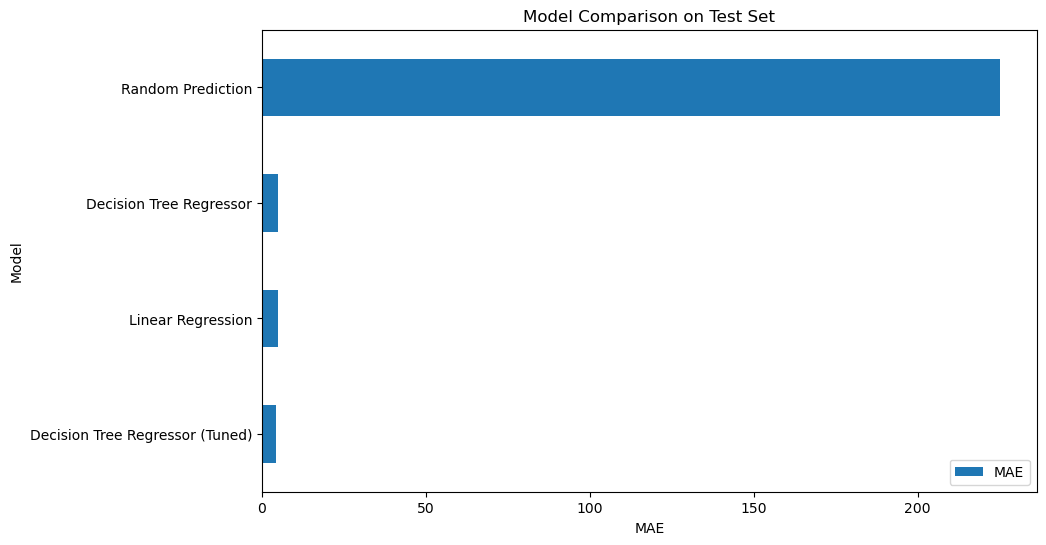

,Model,MAE,MSE,RMSE,MAPE,Fit_Status
0,Decision Tree Regressor (Tuned),4.364723,65.762300,8.109396,0.450155,Good fit
1,Linear Regression,4.950223,85.516303,9.247503,0.477452,Good fit
2,Decision Tree Regressor,5.028189,97.241128,9.861092,0.459654,Overfit (high test error)
3,Random Prediction,225.028496,70692.786176,265.881150,15.410399,Good fit


In [8]:
final_metric_result = df_metrics_fit_status[df_metrics_fit_status.Set_Category == "Test"]
final_metric_result = final_metric_result.sort_values(by="MAE").drop(columns=["Set_Category"]).reset_index(drop=True)
final_metric_result.plot(kind="barh", x="Model", y=["MAE"], figsize=(10, 6), title="Model Comparison on Test Set")
plt.xlabel("MAE")
plt.show()
final_metric_result

Text(0.5, 1.0, 'Model Comparison on Test Set')

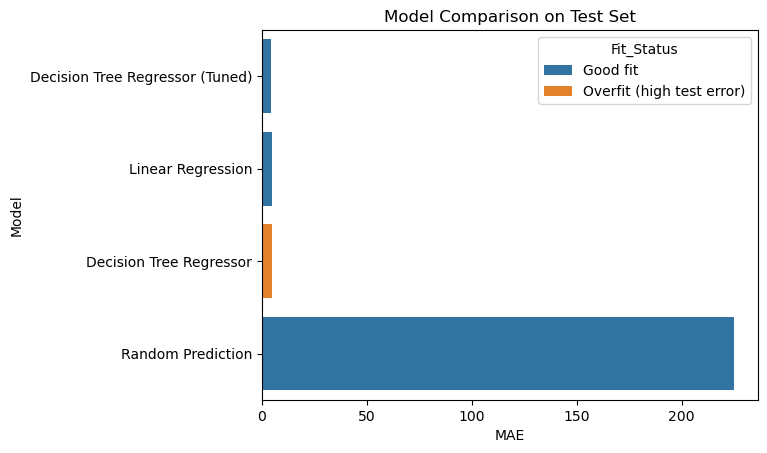

In [9]:
sns.barplot(data=final_metric_result, x="MAE", y="Model", hue="Fit_Status", dodge=False)
plt.title("Model Comparison on Test Set")

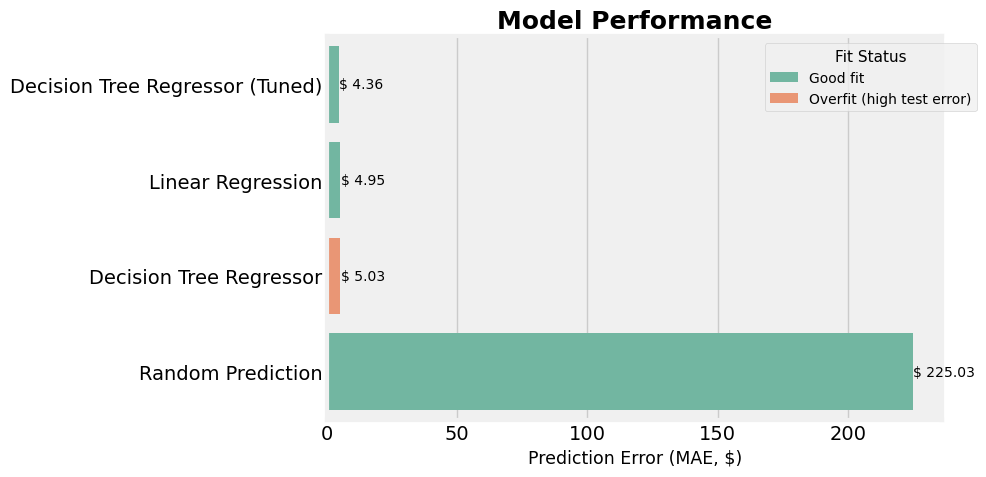

In [10]:
# Better visualization

choosen_metric = "MAE"

plt.figure(figsize=(10, 5))
plt.style.use('fivethirtyeight')

ax = sns.barplot(
    data=final_metric_result,
    x=choosen_metric,
    y="Model",
    hue="Fit_Status",
    dodge=False,
    palette="Set2"       
)

# Add value annotations on bars
for i, patch in enumerate(ax.patches):
    if i>3:continue
    width = patch.get_width()
    y = patch.get_y() + patch.get_height() / 2
    ax.text(
        width + 0.001 * ax.get_xlim()[1], 
        y,
        f"$ {width:,.2f}",
        va="center",
        ha="left",
        fontsize=10,
    )

ax.set_xlabel(f"Prediction Error ({choosen_metric}, $)", fontsize=12.5)
ax.set_ylabel("", fontsize=12)
ax.set_title("Model Performance", fontsize=18, fontweight="bold")
ax.legend(title="Fit Status", bbox_to_anchor=(.7, 1), loc="upper left", fontsize=10, title_fontsize=11)

plt.tight_layout()
plt.show()
